In [20]:
import pandas as pd
from fbprophet import Prophet


In [21]:
df = pd.read_csv("DATA CANAL HOSP.csv")
df.head()

,ds,y
0,01/01/2018,25.6
1,02/01/2018,12.8
2,03/01/2018,0.8
3,04/01/2018,10.4
4,05/01/2018,21.6


Ajustamos el modelo creando una instancia de un nuevo objeto Prophet. Cualquier configuración del procedimiento de previsión se pasa al constructor. Luego llama a su método de ajuste y pasa el marco de datos histórico. El ajuste debería llevar de 1 a 5 segundos.


In [22]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


A continuación, se realizan predicciones en un marco de datos con una columna ds que contiene las fechas para las que se realizará una predicción. Puede obtener un marco de datos adecuado que se extienda en el futuro un número específico de días utilizando el método auxiliar Prophet.make_future_dataframe. De forma predeterminada, también incluirá las fechas del historial, por lo que también veremos el ajuste del modelo.


In [23]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
391,2021-06-27
392,2021-06-28
393,2021-06-29
394,2021-06-30
395,2021-07-01


El método de predicción asignará a cada fila en el futuro un valor predicho que denomina yhat. Si pasa las fechas históricas, proporcionará un ajuste en la muestra. El objeto de pronóstico aquí es un nuevo marco de datos que incluye una columna yhat con el pronóstico, así como columnas para componentes e intervalos de incertidumbre.

In [24]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
391,2021-06-27,-40.391755,-47.945672,-32.354365
392,2021-06-28,-29.141339,-37.529724,-20.855533
393,2021-06-29,-16.923457,-24.731284,-8.296253
394,2021-06-30,-4.011356,-12.698887,3.960812
395,2021-07-01,9.300592,1.232116,17.107370


Puede trazar el pronóstico llamando al método Prophet.plot y pasando su marco de datos de pronóstico.

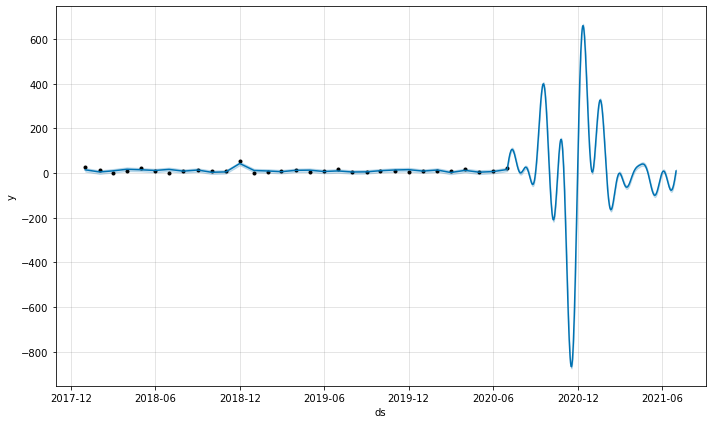

In [25]:
fig1 = m.plot(forecast)


Si desea ver los componentes del pronóstico, puede usar el método Prophet.plot_components. De forma predeterminada, verá la tendencia, la estacionalidad anual y la estacionalidad semanal de la serie temporal. Si incluye días festivos, también los verá aquí.

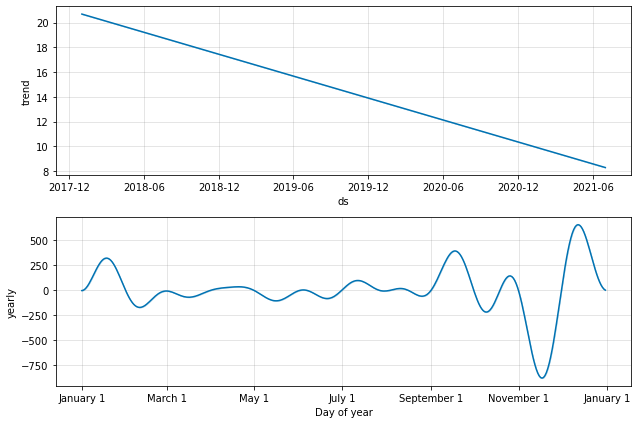

In [26]:

# Python
fig2 = m.plot_components(forecast)


Se puede crear una figura interactiva del pronóstico y los componentes con plotly. Deberá instalar plotly 4.0 o superior por separado, ya que no se instalará de forma predeterminada con fbprophet. También necesitará instalar los paquetes notebook e ipywidgets.

In [27]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [10]:
plot_components_plotly(m, forecast)


## Forecasting Growth


De forma predeterminada, Prophet utiliza un modelo lineal para su pronóstico. Cuando se pronostica el crecimiento, generalmente hay un punto máximo alcanzable: tamaño total del mercado, tamaño total de la población, etc. Esto se denomina capacidad de carga, y el pronóstico debería saturarse en este punto.

Prophet le permite hacer pronósticos utilizando un modelo de tendencia de crecimiento logístico, con una capacidad de carga específica. 

Debemos especificar la capacidad de carga en una tapa de columna. Aquí asumiremos un valor particular, pero esto generalmente se establecería utilizando datos o experiencia sobre el tamaño del mercado.

In [11]:
df['cap'] = 3


Lo importante a tener en cuenta es que el límite debe especificarse para cada fila en el marco de datos y que no tiene que ser constante. Si el tamaño del mercado está creciendo, entonces el límite puede ser una secuencia creciente.

Luego ajustamos el modelo como antes, excepto que pasamos un argumento adicional para especificar el crecimiento logístico:

In [12]:
m = Prophet(growth='logistic')
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


Hacemos un marco de datos para predicciones futuras como antes, excepto que también debemos especificar la capacidad en el futuro. Aquí mantenemos la capacidad constante al mismo valor que en el historial y pronosticamos 5 años en el futuro:

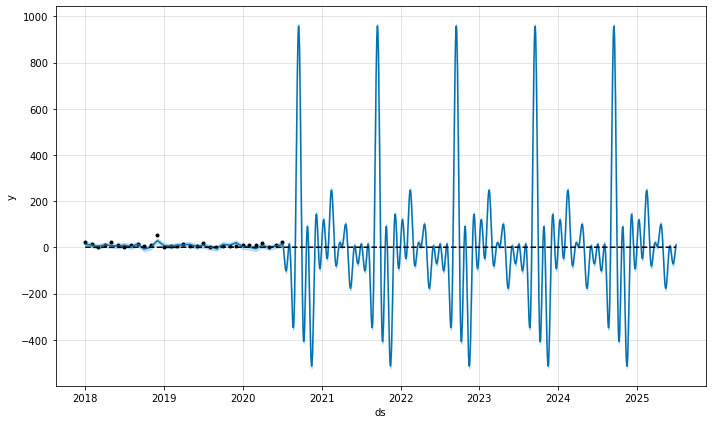

In [13]:
future = m.make_future_dataframe(periods=1826)
future['cap'] = 1
fcst = m.predict(future)
fig = m.plot(fcst)

La función logística tiene un mínimo implícito de 0 y se saturará en 0 de la misma manera que se saturará en la capacidad. También es posible especificar un mínimo de saturación diferente.

## Mínimo de saturación

El modelo de crecimiento logístico también puede manejar un mínimo de saturación, que se especifica con un piso de columna de la misma manera que la columna de límite especifica el máximo:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


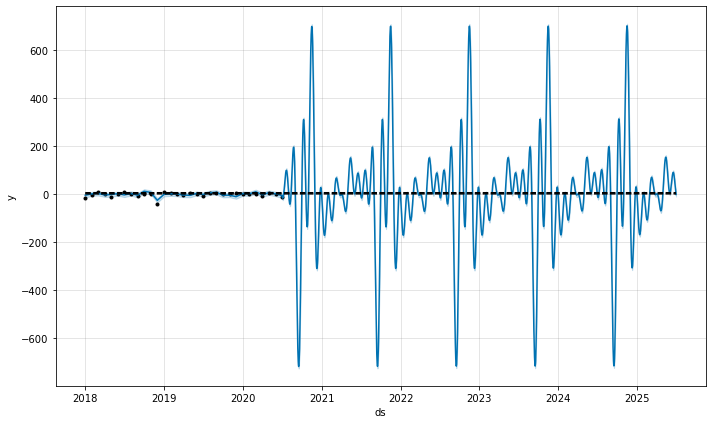

In [14]:
df['y'] = 10 - df['y']
df['cap'] = 6
df['floor'] = 1.5
future['cap'] = 6
future['floor'] = 1.5
m = Prophet(growth='logistic')
m.fit(df)
fcst = m.predict(future)
fig = m.plot(fcst)

Para utilizar una tendencia de crecimiento logístico con un mínimo de saturación, también se debe especificar una capacidad máxima


Puede utilizar Prophet para ajustar los datos mensuales. Sin embargo, el modelo subyacente es de tiempo continuo, lo que significa que puede obtener resultados extraños si ajusta el modelo a los datos mensuales y luego solicita pronósticos diarios.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


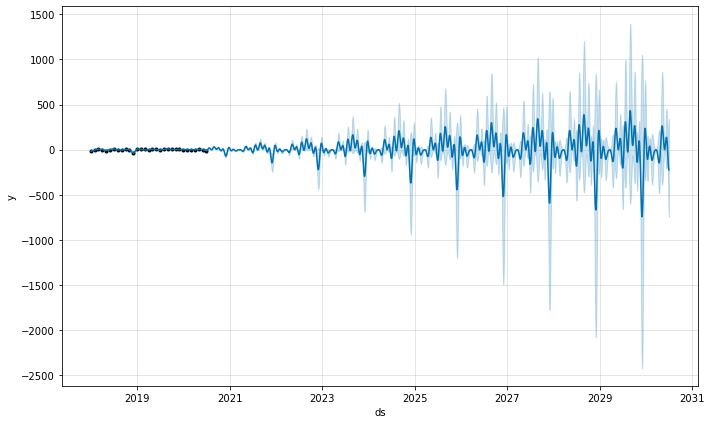

In [15]:
m = Prophet(seasonality_mode='multiplicative').fit(df)
future = m.make_future_dataframe(periods=3652)
fcst = m.predict(future)
fig = m.plot(fcst)

Este es el mismo problema de arriba donde el conjunto de datos tiene lagunas regulares. Cuando ajustamos la estacionalidad anual, solo tiene datos para el primer día de cada mes y los componentes de estacionalidad para los días restantes no son identificables y están sobreajustados. Esto se puede ver claramente haciendo MCMC para ver la incertidumbre en la estacionalidad:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
c:\users\mandupa1.lanet\anaconda3\envs\tesis\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



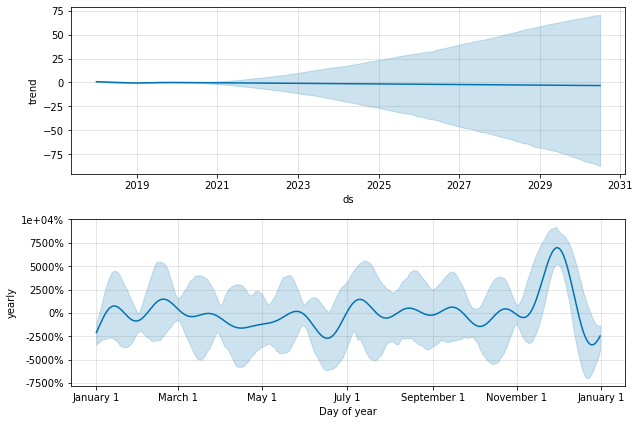

In [16]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(df)
fcst = m.predict(future)
fig = m.plot_components(fcst)

La estacionalidad tiene poca incertidumbre al comienzo de cada mes cuando hay puntos de datos, pero tiene una varianza posterior muy alta en el medio. Al ajustar Prophet a los datos mensuales, solo haga pronósticos mensuales, lo que se puede hacer pasando la frecuencia a make_future_dataframe:

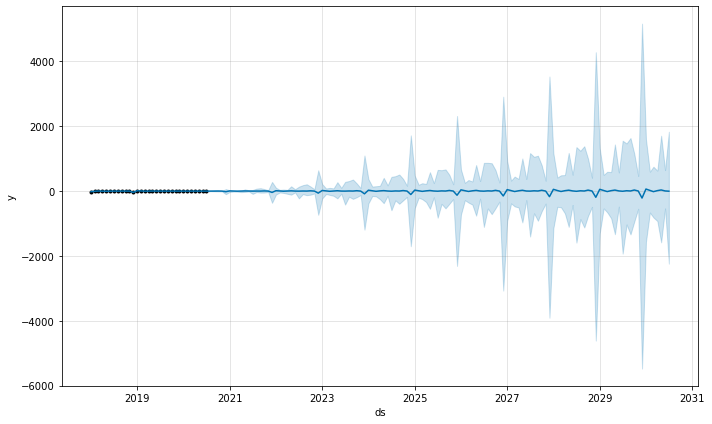

In [17]:
future = m.make_future_dataframe(periods=120, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)